In [1]:
import pandas as pd
import numpy as np
#uploaded = files.upload()
from matplotlib import pyplot as plt

import seaborn as sns

In [2]:
french_categories = {'characteristics': 'caracteristiques', 'places':'lieux', 'users':'usagers', 'vehicles':'vehicules'}
data_categories = french_categories.keys()
categories_dict = dict(zip(data_categories, [0,0,0,0]))


In [3]:
# Define the function that reads the raw data for the specified time range
def read_csv_of_year(start_year, end_year, separators, name_separator='_'):
    if len (separators)<4:
        separators = [separators]*4
        
    df_dict = {}
    for year in range(start_year,end_year+1):
        this_year_str = str(year)
        # Data Category
        this_df_dict = {}        
        for this_category, this_sep in zip(data_categories, separators):
            # We need the French name of the category for the filename
            this_french_category = french_categories[this_category]
            this_file_path_and_name = '../Data/'+this_year_str+'/' + this_french_category+name_separator+this_year_str+'.csv'
            this_df_dict[this_category] = pd.read_csv(this_file_path_and_name, encoding='latin-1', sep=this_sep, low_memory=False)
        df_dict[year] = this_df_dict
    return df_dict

# Import years
df_dict = {}
df_dict.update(read_csv_of_year(2005, 2008, separators=','))
df_dict.update(read_csv_of_year(2009,2009, separators=['\t', ',', ',', ',']))
df_dict.update(read_csv_of_year(2010, 2016, separators=','))
df_dict.update(read_csv_of_year(2017, 2018, separators=',', name_separator='-'))
df_dict.update(read_csv_of_year(2019, 2021, separators=';', name_separator='-'))


## Put all the data in one dataframe for each category

In [4]:
dict_of_category_dfs = {}
for this_category in data_categories:
    dict_of_category_dfs[this_category] = pd.concat([df_dict[year][this_category] for year in range(2005,2022)], ignore_index=True)

characteristics = dict_of_category_dfs['characteristics']
places = dict_of_category_dfs['places']
users = dict_of_category_dfs['users']
vehicles = dict_of_category_dfs['vehicles']

# Data Cleaning
We will perform some of the cleaning of the data on the individual datasets. Not all cleaning is possible before merging the datasets, so there will be a second round of cleaning.

In [5]:
places.columns

Index(['Num_Acc', 'catr', 'voie', 'v1', 'v2', 'circ', 'nbv', 'pr', 'pr1',
       'vosp', 'prof', 'plan', 'lartpc', 'larrout', 'surf', 'infra', 'situ',
       'env1', 'vma'],
      dtype='object')

## Calculate the percentage of missing values for each dataframe

In [6]:
def na_percentage(df):
  return df.isna().sum() *100 / len(df)
  

In [7]:
for this_category, df in dict_of_category_dfs.items():
    print(this_category+'\n', na_percentage(df),'\n')

characteristics
 Num_Acc     0.000000
an          0.000000
mois        0.000000
jour        0.000000
hrmn        0.000000
lum         0.000000
agg         0.000000
int         0.000000
atm         0.006509
col         0.001694
com         0.000178
adr        12.774581
gps        57.198251
lat        43.427300
long       43.427656
dep         0.000000
dtype: float64 

places
 Num_Acc     0.000000
catr        0.000089
voie        9.556239
v1         56.690481
v2         95.419907
circ        0.140339
nbv         0.243498
pr         42.394463
pr1        42.556646
vosp        0.246173
prof        0.173774
plan        0.203375
lartpc     19.511203
larrout    10.060977
surf        0.171545
infra       0.482181
situ        0.443128
env1       15.027314
vma        85.457720
dtype: float64 

users
 Num_Acc         0.000000
place           4.906241
catu            0.000000
grav            0.000000
sexe            0.000000
trajet          0.019684
secu           16.893474
locp            2.245798

## Users Dataset

Dropping unwanted columns , which are num_veh , and id_vehicule


In [8]:
users = users.drop(columns=['num_veh','id_vehicule']) #Not needed

## Places Dataset

In [9]:
# Change french names against english names (Teamdecision)
# Droped 'Unnamed: 0','v1','v2','vma', because they contained no information.

places = places.drop(['v1','v2','vma'], axis = 1)
places = places.rename(columns = {'catr' : 'Rd_Cat', 'voie' : 'Rd_Nr' , 'circ' : 'Traf_Direct' , 'nbv' : 'Lanes' ,
                           'pr' : 'Geoloc' , 'pr1' : 'Dist_to_Geoloc', 'vosp' : 'Add_Lanes', 'prof' : 'Rd_Prof' ,
                          'plan' : 'Rd_Plan' , 'lartpc' : 'Gre_Verge' , 'larrout' : 'Rd_Width', 'surf' : 'Rd_Cond',
                          'infra' : 'Envinmt' , 'situ' : 'Pos_Acc' , 'env1' : 'School'})
places.head()

,Num_Acc,Rd_Cat,Rd_Nr,Traf_Direct,Lanes,Geoloc,Dist_to_Geoloc,Add_Lanes,Rd_Prof,Rd_Plan,Gre_Verge,Rd_Width,Rd_Cond,Envinmt,Pos_Acc,School
0,200500000001,3.0,41.0,2.0,2.0,1.0,430.0,0.0,1.0,1.0,0,63,1.0,0.0,1.0,0.0
1,200500000002,2.0,41.0,0.0,2.0,0.0,0.0,1.0,1.0,1.0,0,100,1.0,0.0,5.0,0.0
2,200500000003,2.0,41.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0,0,2.0,0.0,5.0,0.0
3,200500000004,3.0,916.0,2.0,2.0,0.0,0.0,0.0,1.0,1.0,0,0,1.0,0.0,1.0,0.0
4,200500000005,3.0,110.0,2.0,2.0,24.0,630.0,0.0,1.0,3.0,0,59,2.0,0.0,3.0,0.0


### Change Nans against zeros

Set most empty varibles to Zero / Null, because its for all vaiables not in use and can be defined as not applicable.

9 Variables have <= 1% missing information, so for those it should be fine to set the missing information just tu zero.

Hoped to fill up the missing information for Rd_Width with a comparsion Rd_Nr vs. Rd_Width, but it turns out that the same street has different widths.

Nr_n_Width = places[['Rd_Nr','Rd_Width','Gre_Verge']]#comparsion Rd_Nr vs. Rd_Width. Same for Gre_Verge.
Nr_n_Width.head()

Geoloc and Dist_to_Geoloc are information to localize an accident. I dont have the informaton how this numbers are created, so at the moment I filled missing information with zeros.
I did not found any information regardind this problem, so I will change the names to zeros.

Missing information of Rd_Nr, biggest problem is that later in the Datasets they changed input of numbers against names. So I need a list which says which street is which number.

For column school there are 3 Types of information 99.0 / 0.0 and 3.0, according to the description the variable schools should only contain 1 or 2 so if it is or not near by a school.
In 2019 they droped this column and start with speed limits. Its a importent information but I cant use it in this format. I will drop it for the moment.
Code
sns.countplot( x = places.School)

In [10]:
places = places.drop(['School'], axis = 1)
places['Rd_Cat'] = places['Rd_Cat'].fillna(0.0)
places['Traf_Direct'] = places['Traf_Direct'].fillna(0.0)
places['Lanes'] = places['Lanes'].fillna(0.0)
places['Geoloc'] = places['Geoloc'].fillna(0.0)
places['Dist_to_Geoloc'] = places['Dist_to_Geoloc'].fillna(0.0)
places['Add_Lanes'] = places['Add_Lanes'].fillna(0.0)
places['Rd_Prof'] = places['Rd_Prof'].fillna(0.0)
places['Rd_Plan'] = places['Rd_Plan'].fillna(0.0)
places['Gre_Verge'] = places['Gre_Verge'].fillna(0.0)
places['Rd_Width'] = places['Rd_Width'].fillna(0.0)
places['Rd_Cond'] = places['Rd_Cond'].fillna(0.0)
places['Envinmt'] = places['Envinmt'].fillna(0.0)
places['Pos_Acc'] = places['Pos_Acc'].fillna(0.0)
places['Rd_Nr'] = places['Rd_Nr'].fillna(0.0)

In [11]:
# Convert object to float
places['Geoloc'] = pd.to_numeric(places['Geoloc'],errors = 'coerce')
places['Dist_to_Geoloc'] = pd.to_numeric(places['Dist_to_Geoloc'],errors = 'coerce')
places['Gre_Verge'] = pd.to_numeric(places['Gre_Verge'],errors = 'coerce')
places['Rd_Width'] = pd.to_numeric(places['Rd_Width'],errors = 'coerce')
places['Rd_Nr'] = pd.to_numeric(places['Rd_Nr'],errors = 'coerce')

# replace empty cells with nans
places.replace('', np.nan)
places = places.copy()

# fill nans with 0
places['Rd_Nr'] = places['Rd_Nr'].fillna(0.0)
places['Geoloc'] = places['Geoloc'].fillna(0.0)
places['Dist_to_Geoloc'] = places['Dist_to_Geoloc'].fillna(0.0)
places['Gre_Verge'] = places['Gre_Verge'].fillna(0.0)
places['Rd_Width'] = places['Rd_Width'].fillna(0.0)

# Convert float to int
places['Rd_Cat'] = places['Rd_Cat'].astype(int, errors = 'raise')
places['Rd_Nr'] = places['Rd_Nr'].astype(int, errors = 'raise')
places['Traf_Direct'] = places['Traf_Direct'].astype(int, errors = 'raise')
places['Lanes'] = places['Lanes'].astype(int, errors = 'raise')
places['Geoloc'] = places['Geoloc'].astype(int, errors = 'raise')
places['Dist_to_Geoloc'] = places['Dist_to_Geoloc'].astype(int, errors = 'raise')
places['Add_Lanes'] = places['Add_Lanes'].astype(int, errors = 'raise')
places['Rd_Prof'] = places['Rd_Prof'].astype(int, errors = 'raise')
places['Rd_Plan'] = places['Rd_Plan'].astype(int, errors = 'raise')
places['Gre_Verge'] = places['Gre_Verge'].astype(int, errors = 'raise')
places['Rd_Width'] = places['Rd_Width'].astype(int, errors = 'raise')
places['Rd_Cond'] = places['Rd_Cond'].astype(int, errors = 'raise')
places['Envinmt'] = places['Envinmt'].astype(int, errors = 'raise')
places['Pos_Acc'] = places['Pos_Acc'].astype(int, errors = 'raise')

print(places.isna().sum())
print()
print(places.info())
print()
print(places.shape)#it appears that there is a problem with the shape of the df (couldnt normalize) ValueError: Found array with dim 3. the normalize function expected <= 2.


Num_Acc           0
Rd_Cat            0
Rd_Nr             0
Traf_Direct       0
Lanes             0
Geoloc            0
Dist_to_Geoloc    0
Add_Lanes         0
Rd_Prof           0
Rd_Plan           0
Gre_Verge         0
Rd_Width          0
Rd_Cond           0
Envinmt           0
Pos_Acc           0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1121571 entries, 0 to 1121570
Data columns (total 15 columns):
 #   Column          Non-Null Count    Dtype
---  ------          --------------    -----
 0   Num_Acc         1121571 non-null  int64
 1   Rd_Cat          1121571 non-null  int32
 2   Rd_Nr           1121571 non-null  int32
 3   Traf_Direct     1121571 non-null  int32
 4   Lanes           1121571 non-null  int32
 5   Geoloc          1121571 non-null  int32
 6   Dist_to_Geoloc  1121571 non-null  int32
 7   Add_Lanes       1121571 non-null  int32
 8   Rd_Prof         1121571 non-null  int32
 9   Rd_Plan         1121571 non-null  int32
 10  Gre_Verge       1121571 non-

## Characteristics Dataset

### Translate variable names from French to English

In [12]:
# Translation of the variable nacmes from French to English, also improving the names so that it becomes clearer, what they are about
characteristics.rename(columns={'an': 'year', 'mois':'month', 'jour': 'day', 'hrmn':'hhmm', 
                                'lum': 'daylight', 'agg': 'built-up_area', 'int':'intersection_category', 'atm': 'atmospheric_conditions',
                                'col': 'collision_category', 'com': 'municipality', 'adr':'adress', 'gps': 'gps_origin', 'lat': 'latitude',
                                'long': 'longitude', 'dep': 'department'}, inplace=True)

# Change the values for 'built-up_area' to make it more understandable, 1 means the accident happened in a built-up area and 0 means happened elsewhere. 
characteristics['built-up_area'].replace({1:0, 2:1}, inplace=True)

### Fixing incoherent format of year variable

In [13]:
dict_of_category_dfs['characteristics']['year'].value_counts()

5       87026
7       83850
6       82993
8       76767
9       74409
10      69379
11      66974
12      62250
17      60701
14      59854
16      59432
2019    58840
15      58654
13      58397
18      57783
2021    56518
2020    47744
Name: year, dtype: int64

The year format is inconsistent. Until 2018, the year was relative to the year 2000, e.g. "5" for 2005. This changed, however, in 2019 which was labeled as 2019.
We will change the year format to YYYY.

In [14]:
dict_of_category_dfs['characteristics']['year'].replace({5:2005, 6:2006, 7:2007, 8:2008, 9:2009, 10:2010, 11:2011,
                                                         12:2012, 13:2013, 14:2014, 15:2015, 16:2016, 17:2017, 18:2018}, inplace=True)

#### Check

In [15]:
dict_of_category_dfs['characteristics']['year'].value_counts()

2005    87026
2007    83850
2006    82993
2008    76767
2009    74409
2010    69379
2011    66974
2012    62250
2017    60701
2014    59854
2016    59432
2019    58840
2015    58654
2013    58397
2018    57783
2021    56518
2020    47744
Name: year, dtype: int64

### Fix inconsistent time format

The time format inconsistent, sometimes it is hhmm, and sometimes hh:mm. We will therefore remove any ":" from the column 

In [16]:
#remove ':' from hhmm
dict_of_category_dfs['characteristics']['hhmm'] = dict_of_category_dfs['characteristics']['hhmm'].apply(lambda s: int(str(s).replace(':','')))


### Get weekday and weekend feature

In [17]:
dict_of_category_dfs['characteristics']['date'] = pd.to_datetime({'year':dict_of_category_dfs['characteristics']['year'],
                                                                 'month':dict_of_category_dfs['characteristics']['month'],
                                                                 'day':dict_of_category_dfs['characteristics']['day']})

In [18]:
# New variable: weekday, integer from 0 to 6 representing the weekdays from monday to sunday.
dict_of_category_dfs['characteristics']['day_of_week'] = dict_of_category_dfs['characteristics']['date'].apply(lambda x: x.day_of_week)

# New binary variable: is_weekend, 0 for monday to friday and 1 for saturday and sunday
dict_of_category_dfs['characteristics']['is_weekend'] = (dict_of_category_dfs['characteristics']['day_of_week'] > 4).astype('int')

# Merge all datasets

## Compute the percentage of missing data

In [19]:
outer_df = characteristics.merge(right=places, how='outer').merge(users, how='outer').merge(vehicles, how='outer')

In [20]:
print(f'number of rows:........{outer_df.shape[0]}')
print(f'number of variables:...{outer_df.shape[1]}')
na_percentage(outer_df)

number of rows:........4763230
number of variables:...56


Num_Acc                    0.000000
year                       0.000000
month                      0.000000
day                        0.000000
hhmm                       0.000000
daylight                   0.000000
built-up_area              0.000000
intersection_category      0.000000
atmospheric_conditions     0.005521
collision_category         0.001994
municipality               0.000336
adress                    14.200448
gps_origin                56.132162
latitude                  42.305830
longitude                 42.306250
department                 0.000000
date                       0.000000
day_of_week                0.000000
is_weekend                 0.000000
Rd_Cat                     0.000000
Rd_Nr                      0.000000
Traf_Direct                0.000000
Lanes                      0.000000
Geoloc                     0.000000
Dist_to_Geoloc             0.000000
Add_Lanes                  0.000000
Rd_Prof                    0.000000
Rd_Plan                    0

## Left Join for further investigations
We will continue working with the left join of the data, as the missing lines miss the most important variables anyway.

In [21]:
df = characteristics.merge(right=places, how='left').merge(users, how='left').merge(vehicles, how='left')
print(df.info())
print(na_percentage(df))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4763230 entries, 0 to 4763229
Data columns (total 56 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   Num_Acc                 int64         
 1   year                    int64         
 2   month                   int64         
 3   day                     int64         
 4   hhmm                    int64         
 5   daylight                int64         
 6   built-up_area           int64         
 7   intersection_category   int64         
 8   atmospheric_conditions  float64       
 9   collision_category      float64       
 10  municipality            object        
 11  adress                  object        
 12  gps_origin              object        
 13  latitude                object        
 14  longitude               object        
 15  department              object        
 16  date                    datetime64[ns]
 17  day_of_week             int64         
 18  is

## Correlation of the feature variables with the target

In [22]:
cm=df.corr()
cm["grav"].sort_values(ascending=False)[1:]

catu                      0.203123
secu                      0.158592
locp                      0.134068
secu1                     0.114347
sexe                      0.106052
an_nais                   0.101691
etatp                     0.097808
secu2                     0.097510
place                     0.086411
obs                       0.062583
Rd_Cat                    0.034733
secu3                     0.032042
Pos_Acc                   0.028908
daylight                  0.027986
built-up_area             0.021525
collision_category        0.019920
Rd_Plan                   0.019036
is_weekend                0.009010
senc                      0.007589
Rd_Cond                   0.006170
day_of_week               0.004732
catv                      0.003977
motor                     0.003420
Num_Acc                   0.002592
year                      0.002591
intersection_category     0.002265
Rd_Prof                   0.001578
Rd_Nr                     0.001155
day                 

The list shows the correlation between each variables and the target variable. Note: The decision whether a variable is important or not has to be based on the absolute value of the correlation.

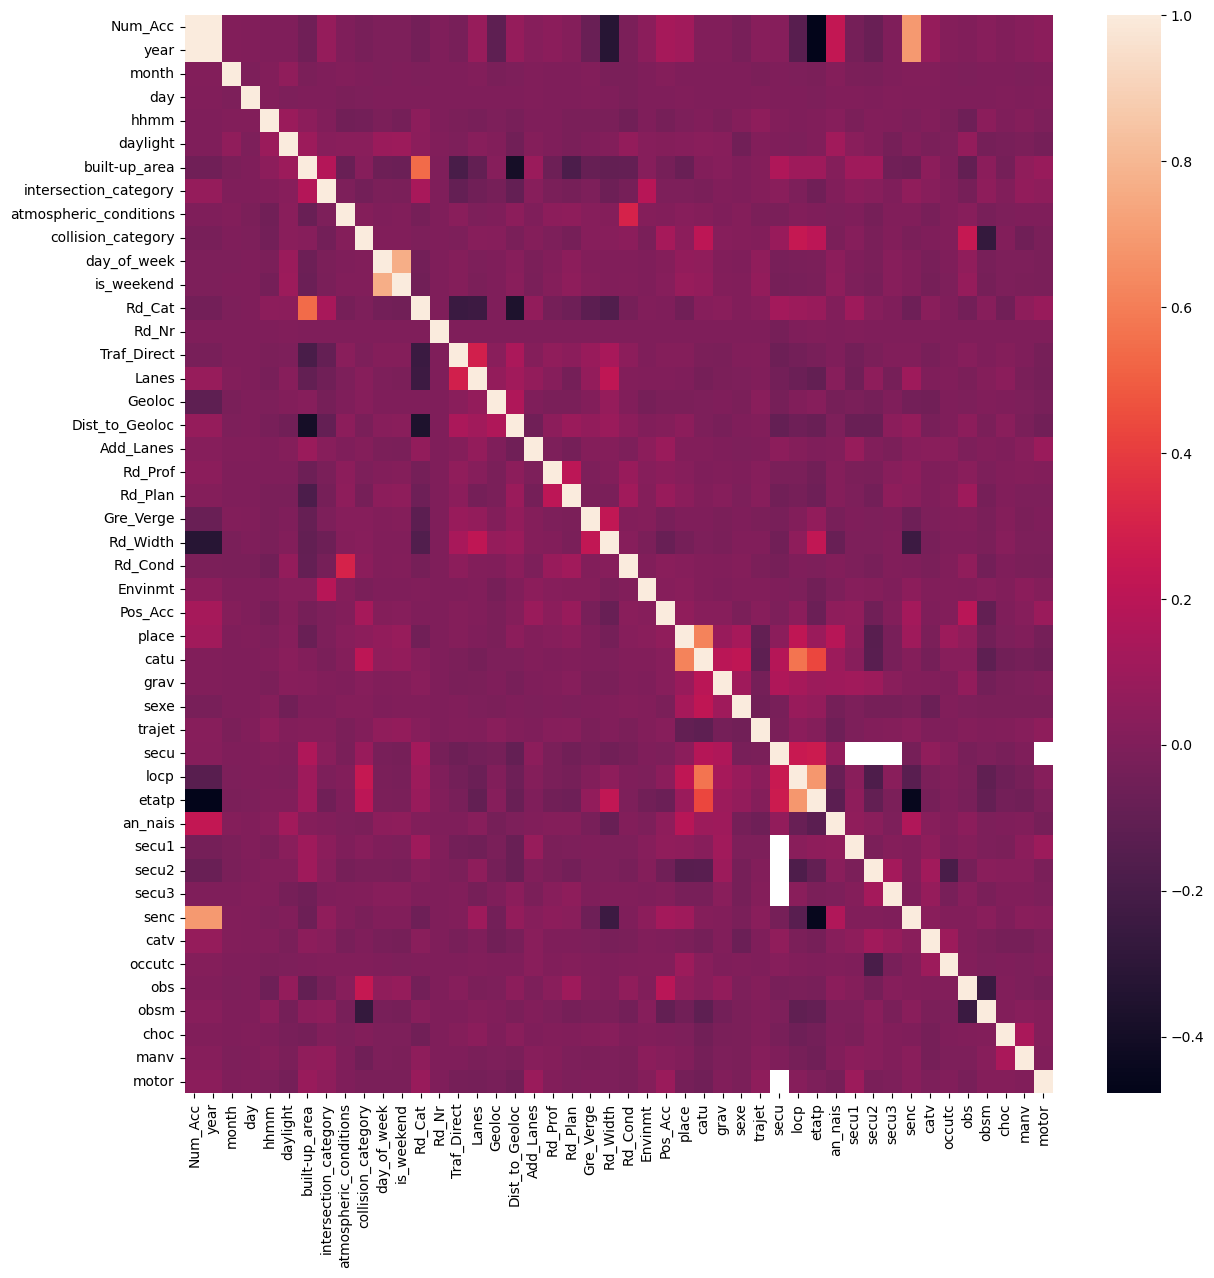

In [23]:
plt.figure(figsize=(14,14));
sns.heatmap(cm, annot=False);

## Fixing incoherency of 'secu' Variable
Safety equipment until 2018 was in 2 variables: existence and use.

From 2019, it is the use with up to 3 possible equipments for the same user
(especially for motorcyclists whose helmet and gloves are mandatory).

### secu1
The character information indicates the presence and use of the safety equipment:
-1 - No information
0 - No equipment
1 - Belt
2 - Helmet
3 - Children device
4 - Reflective vest
5 - Airbag (2WD/3WD)
6 - Gloves (2WD/3WD)
7 - Gloves + Airbag (2WD/3WD)
8 - Non-determinable
9 - Other

### secu2
The character information indicates the presence and use of the safety equipment

### secu3
The character information indicates the presence and use of safety equipment


In [24]:
df['secu'] = df[df['year']==2007]['secu'].astype(int)
df[df['year']==2007]['secu'].value_counts()

11.0    207712
21.0     64473
13.0     30639
0.0      19429
93.0      9452
23.0      7176
12.0      5444
22.0      3502
31.0      2697
10.0      1760
92.0      1279
91.0      1247
43.0       307
41.0       281
33.0       235
20.0       235
42.0       153
32.0       146
90.0        58
30.0         2
40.0         1
Name: secu, dtype: int64

# Visualizations

## Datetime

We suspect different distributions on weekdays in comparison to weekends. Accidents on weekdays will probably occur mostly when people are commuting to work, i.d. before 09:00 and after 17:00, while on the weekends, people might cause accidents when they return from parties late at night.
We will plot the relative distribution of accidents in two histograms in one figure.
The proportion is relative to the total number of accidents in each category, i.e. 1 different for weekends and weekends.

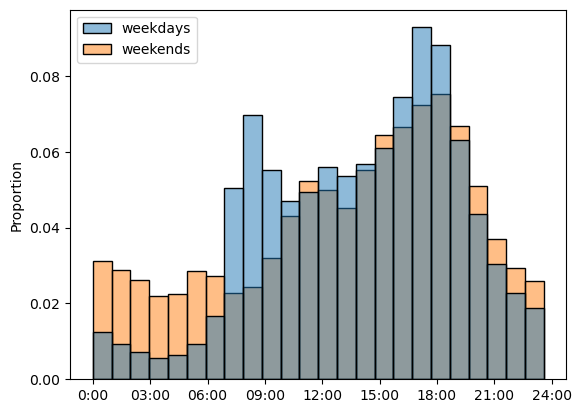

In [25]:
day_time_ticks = (0,300,600,900,1200,1500,1800,2100,2400)
day_time_tick_labels = ('0:00', '03:00','06:00','09:00','12:00','15:00',
                   '18:00','21:00','24:00')
plot_data = pd.DataFrame({'weekdays': (dict_of_category_dfs['characteristics'][dict_of_category_dfs['characteristics']['is_weekend'] != 1 ])['hhmm'],
                 'weekends': (dict_of_category_dfs['characteristics'][dict_of_category_dfs['characteristics']['is_weekend'] == 1 ])['hhmm']})
fig= plt.figure();
sns.histplot(data=plot_data, stat='proportion', bins=24, common_norm=False);
plt.xticks(ticks=day_time_ticks, 
           labels=day_time_tick_labels);

The plot shows, that the temporal distribution is different on the weekends: On weekends, there are far more accidents between 19:00 and 07:00, while there are more accidents on weekday around 09:00 and 18:00. These differences align very well with our hypothesis. We did not expect the peak on weekends around 18:00, though. 

Possible policy measures could be more public transport offers during these times and more police inspections on the weekends near party locations.

## Accidents per capita

In [26]:
# Importing data departments from 2019
# source: https://www.insee.fr/fr/statistiques/6011070?sommaire=6011075
departments_2019_df = pd.read_csv('../Data/additional_data/donnees_departements.csv', index_col=2, sep=';')

# number of accidents by department
n_accidents_by_department = dict_of_category_dfs['characteristics']['department'].value_counts()

In [27]:
[n_accidents_by_department.head(10).index, n_accidents_by_department.head(10)]

[Index([750, 130, 930, 920, 940, 60, 690, 590, 330, 910], dtype='object'),
 750    99021
 130    59442
 930    39476
 920    36409
 940    34658
 60     30954
 690    30331
 590    25899
 330    24640
 910    20443
 Name: department, dtype: int64]

The data shows department codes that are not valid with the insee department codes. It is therefore not compatible with the dataset of populations. We will further investigate how this problem can be fixed.

In [28]:
#xticks=[]
#for this_department in n_accidents_by_department.head(10).index:
#    print(this_department)
#    department_name=departments_2019_df.loc[departments_2019_df.index == this_department]
#    print(str(department_name))
#    xticks.append(department_name)


In [29]:
#sns.barplot(x=n_accidents_by_department.head(10).index, y=n_accidents_by_department.head(10), order=n_accidents_by_department.head(10).index)
#xticks = departments_2019_df[:,'CODREG'] == n_accidents_by_department.head(10).index
#plt.xticks(departments_2019_df[])

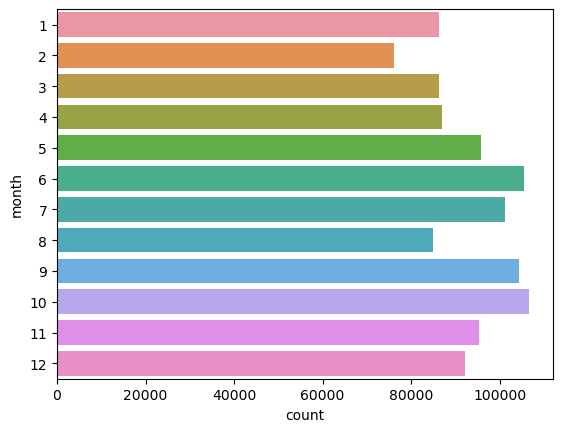

In [30]:
sns.countplot(y = "month" , data = characteristics);

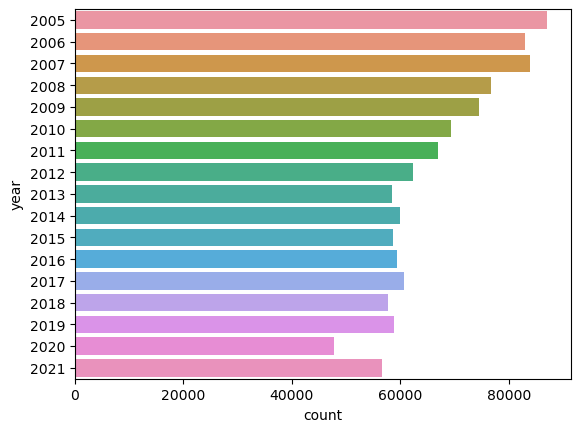

In [31]:
sns.countplot(y = "year" , data = characteristics);

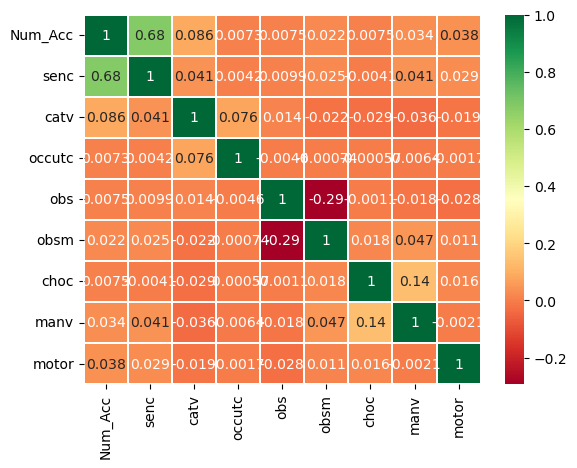

In [32]:
# Displaying dataframe correlations as a heatmap 
# with diverging colourmap as RdYlGn
sns.heatmap(vehicles.corr(), cmap ='RdYlGn', linewidths = 0.30, annot = True);

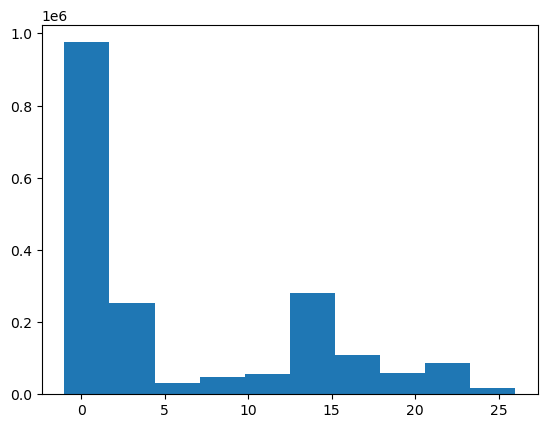

In [33]:
# showing frequency of each manevuer before car accident
plt.hist(vehicles["manv"])
plt.show()

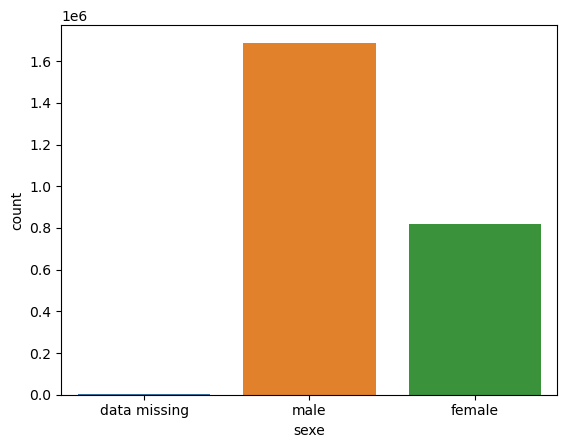

In [34]:
sns.countplot(data=users, x='sexe');
plt.xticks(ticks=[0,1,2],labels=['data missing','male', 'female']);

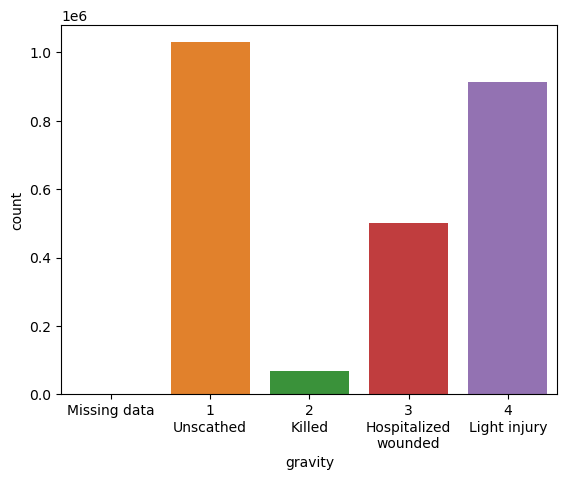

In [35]:
sns.countplot(data=users, x='grav');  
plt.xticks(ticks=[0,1,2,3,4], labels=['Missing data','1\nUnscathed', '2\nKilled',
    '3\nHospitalized\nwounded','4\nLight injury'])
plt.xlabel('gravity');

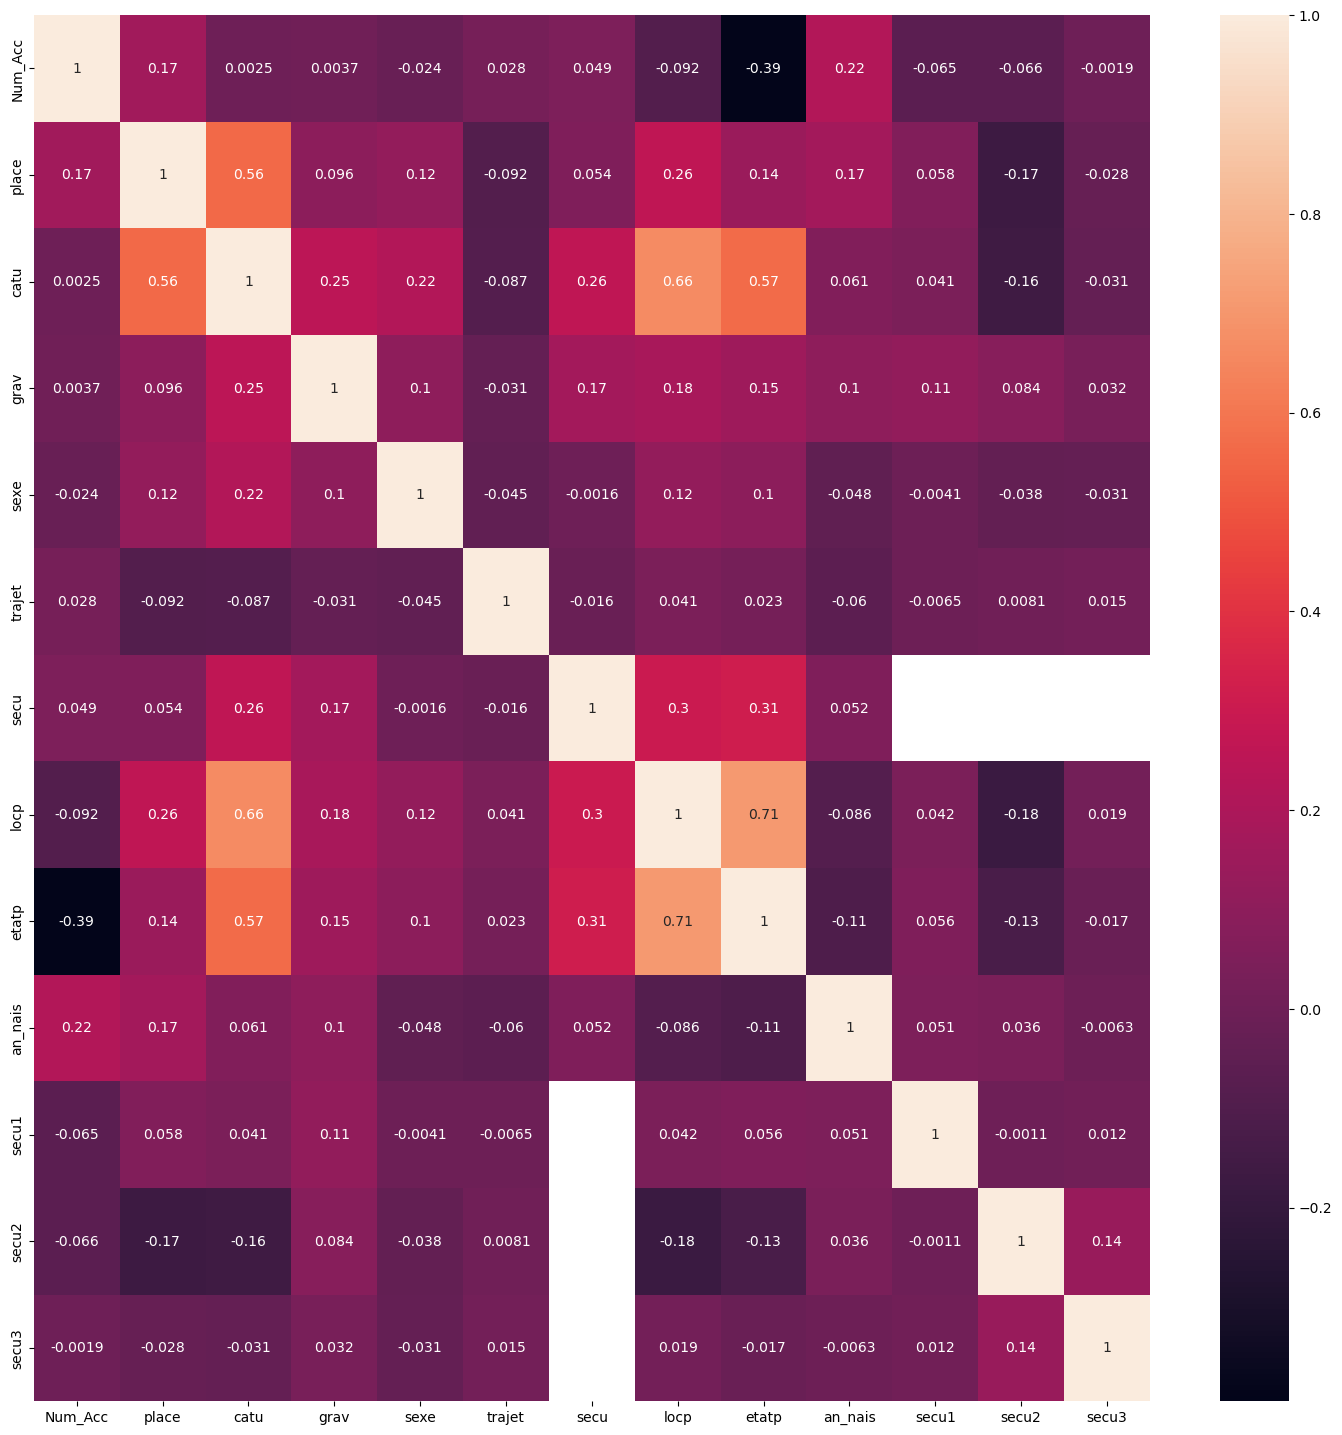

In [36]:
fig, S = plt.subplots(figsize=(18,18));
sns.heatmap(users.corr() , annot = True );

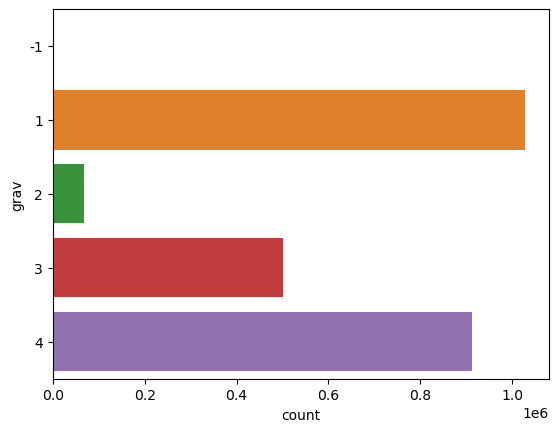

In [37]:
sns.countplot(data=users, y='grav');  #•	1 - Unscathed•	2 - Killed•	3 - Hospitalized wounded•	4 - Light injury

1 = Highway ; 2 = National Road ; 3 = Departmental Road ; 4 = Communal Way ; 5 = Off puplic Network  ; 6 = Parking Lot (puplic) ; 7 = ? ; 8 = ? ; 9 = other

Most accidents happened in town.


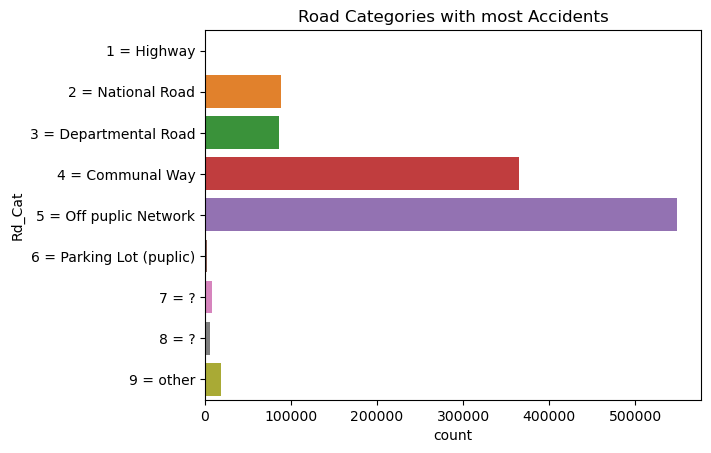

In [38]:
sns.countplot( y = places.Rd_Cat);
plt.title('Road Categories with most Accidents');
print('1 = Highway ; 2 = National Road ; 3 = Departmental Road ; 4 = Communal Way ; 5 = Off puplic Network  ; 6 = Parking Lot (puplic) ; 7 = ? ; 8 = ? ; 9 = other')
print()
print('Most accidents happened in town.')
plt.yticks(ticks=list(range(0,9)),labels=['1 = Highway', '2 = National Road', '3 = Departmental Road', '4 = Communal Way' ,'5 = Off puplic Network','6 = Parking Lot (puplic)' , '7 = ?' , '8 = ?', '9 = other']);

### Plotting the 'Dist_to_Geoloc'-Variable in Order to find out, what this variable is about.

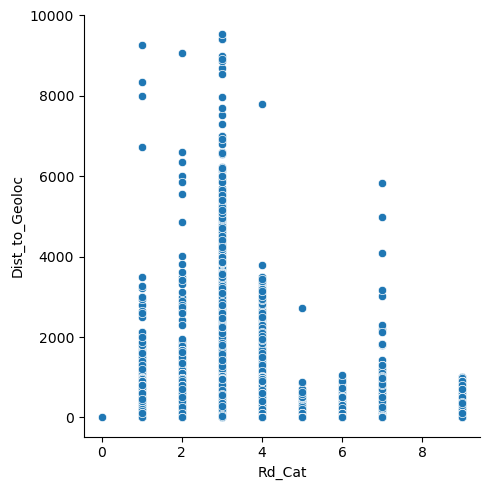

In [39]:
sns.relplot( x = places.Rd_Cat, y = places.Dist_to_Geoloc);

It is still not entirely clear to us, what this variable means.

Rd.Cats: 1 = Highway ; 2 = National Road ; 3 = Departmental Road ; 4 = Communal Way ; 5 = Off puplic Network  ; 6 = Parking Lot (puplic) ; 7 = ? ; 8 = ? ; 9 = other

Traff.Direct: -1 = False ; 0 = False ; 1 = One Way ; 2 = Bidirectional ; 3 = Separated Carriageways ; 4 = With variable assignment Channels

Higher accident risk with oncoming traffic, do we have a lot of frontal collisions?



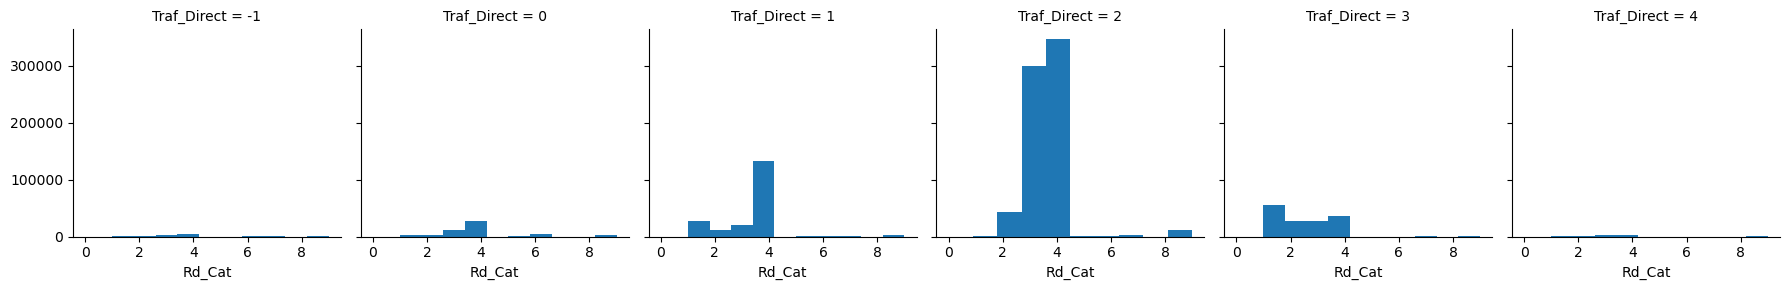

In [40]:
g = sns.FacetGrid(places, col = 'Traf_Direct')
g.map(plt.hist, 'Rd_Cat')
print('Rd.Cats: 1 = Highway ; 2 = National Road ; 3 = Departmental Road ; 4 = Communal Way ; 5 = Off puplic Network  ; 6 = Parking Lot (puplic) ; 7 = ? ; 8 = ? ; 9 = other')
print()
print('Traff.Direct: -1 = False ; 0 = False ; 1 = One Way ; 2 = Bidirectional ; 3 = Separated Carriageways ; 4 = With variable assignment Channels')
print()
print('Higher accident risk with oncoming traffic, do we have a lot of frontal collisions?')
print()

# Export DataFrame to csv
This step is necessary to be able to work with the data in another notebook.

In [41]:
df.to_csv('../Data/df.csv')